# **Train MetaA2C Model on Reversal ABC Multi-Timestep Task**

This notebook trains a Meta-Actor-Critic (MetaA2C) model on the reversal ABC task with multi-timestep trial structure where:
- Stimulus A: Always rewarded in pre-reversal, never in post-reversal
- Stimulus B: Never rewarded in pre-reversal, 50% rewarded in post-reversal
- Stimulus C: Random reward (50% probability, doesn't reverse)

The MetaA2C model uses a shared RNN backbone with feedforward actor and critic heads, enabling the agent to maintain memory across timesteps and use previous actions and rewards as input.

Trial structure:
- Stimulus window: Multiple timesteps showing the stimulus
- Reward availability window: Multiple timesteps where reward can be obtained
- Outcome state: Single timestep showing outcome
- ITI: Random timesteps showing no stimulus

Training approach:
- Train sequentially through phases: first pre-reversal, then post-reversal
- Track metrics continuously across the entire sequence
- Track trial-level metrics at end of stim window
- Visualise with reversal points marked on the plots

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pickle
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent))

from cog_nn.tasks.reversal_envs import ReversalABCMultiTimestepEnv, load_reversal_abc_multitimestep_data
from cog_nn.models import RNNActorCritic
from cog_nn.agents import MetaA2CAgent
from cog_nn.utils import get_dict_key

# Import plot style settings
import cog_nn.plot_style


In [2]:
save_path = Path("/Users/pmccarthy/Documents/modelling_results/december_2025_a2c/reversal_abc_multitimestep")
save_path.mkdir(parents=True, exist_ok=True)
task_data_path = Path("/Users/pmccarthy/Documents/cogNN/task_data")
task = "reversal_abc_multitimestep"

---
Load Task Dataset


In [3]:
# Load reversal ABC multi-timestep task data
data_path = task_data_path / f"{task}.pkl"

try:
    state_sequence, reward_sequence, reversal_mask, phase_boundaries, trial_structure, state_map = \
        load_reversal_abc_multitimestep_data(data_path)
    print(f"Loaded data from {data_path}")
    print(f"State sequence shape: {state_sequence.shape}")
    print(f"Reward sequence shape: {reward_sequence.shape}")
    print(f"Number of trials: {len(trial_structure)}")
    if phase_boundaries:
        print(f"Phase boundaries: {phase_boundaries}")
    
    # Check if data needs to be regenerated (old 5D format vs new 7D format)
    if state_sequence.shape[1] == 5:
        print("\n⚠️  WARNING: Data file contains 5D states (old format).")
        print("   The environment now requires 7D states (with reward_unknown state).")
        print("   Please regenerate the data file using the task generation notebook/script.")
        print("   Or uncomment the cell below to regenerate automatically.")
        raise ValueError("Data file format mismatch: expected 7D states, found 5D")
        
except FileNotFoundError:
    print(f"Data file not found at {data_path}")
    print("Please run task generation first to generate the data")
    raise


Loaded data from /Users/pmccarthy/Documents/cogNN/task_data/reversal_abc_multitimestep.pkl
State sequence shape: (183463, 7)
Reward sequence shape: (183463,)
Number of trials: 8000
Phase boundaries: {'reversal_points': [91579], 'pre_reversal': {'start': 0, 'end': 91579}, 'post_reversal': {'start': 91579, 'end': 183463}}


In [4]:
state_map

{'A': 0,
 'B': 1,
 'C': 2,
 'reward_unknown': 3,
 'unrewarded': 4,
 'rewarded': 5,
 'ITI': 6}

In [5]:
# Create environment
env = ReversalABCMultiTimestepEnv(
    state_sequence,
    reward_sequence,
    reversal_mask,
    trial_structure,
    reward_lick=1.0,      # Higher reward for correct lick
    lick_no_reward=-1.0,  # Less negative for incorrect lick
    no_lick=0.0           # No change for no lick
)

# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"\nEnvironment created:")
print(f"State size: {state_size}")
print(f"Action size: {action_size}")
print(f"Total timesteps: {len(state_sequence)}")



Environment created:
State size: 7
Action size: 2
Total timesteps: 183463


---
Define Model and Agent


In [6]:
# Model hyperparameters
hidden_size = 128  # RNN hidden size
learning_rate = 0.0005
gamma = 0  # Discount factor

# Create MetaA2C agent (includes shared RNN backbone with actor and critic heads)
agent = MetaA2CAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size)

# Add optimizer and gamma to the model (required by update method)
agent.model.optimizer = Adam(agent.model.parameters(), lr=learning_rate)
agent.model.gamma = gamma

print("Model initialised:")
print(f"Gamma (discount factor): {agent.model.gamma}")
print(f"MetaA2C Agent: {agent.model}")


policy_clip_param = 0.25  # Minimum action probability

Model initialised:
MetaA2C Agent: RNNActorCritic(
  (rnn): RNN(10, 128, batch_first=True)
  (actor_fc): Linear(in_features=128, out_features=2, bias=True)
  (critic_fc): Linear(in_features=128, out_features=1, bias=True)
  (softmax): Softmax(dim=-1)
)


---
Training Setup


In [8]:
# Training parameters
batch_size = 1  # Update every N steps

# Get phase boundaries
if phase_boundaries:
    pre_start = phase_boundaries['pre_reversal']['start']
    pre_end = phase_boundaries['pre_reversal']['end']
    post_start = phase_boundaries['post_reversal']['start']
    post_end = phase_boundaries['post_reversal']['end']
    reversal_points = phase_boundaries.get('reversal_points', [])
else:
    # Estimate from reversal_mask
    num_pre_trials = np.sum(reversal_mask == 0)
    num_post_trials = np.sum(reversal_mask == 1)
    # Estimate timesteps (rough approximation)
    avg_trial_length = len(state_sequence) / len(trial_structure) if trial_structure else 20
    pre_end = int(num_pre_trials * avg_trial_length)
    pre_start = 0
    post_start = pre_end
    post_end = len(state_sequence)
    reversal_points = [pre_end]

print(f"Training setup:")
print(f"Pre-reversal phase: timesteps {pre_start} to {pre_end}")
print(f"Post-reversal phase: timesteps {post_start} to {post_end}")
print(f"Reversal points: {reversal_points}")

# Track metrics during training
metrics = {
    'lick_probs': {'A': [], 'B': [], 'C': []},
    'values': {'A': [], 'B': [], 'C': []},
    'rewards': [],
    'reward_timesteps': [],
    'timesteps_A': [],
    'timesteps_B': [],
    'timesteps_C': [],
    # Track within-trial metrics
    'trial_lick_probs': {'A': [], 'B': [], 'C': []},  # Last timestep of stim window per trial
    'trial_values': {'A': [], 'B': [], 'C': []},
    'trial_timesteps': [],
    'trial_indices': [],
    'trial_reversal_phases': [],
    # Track trial boundaries
    'trial_boundaries': [],  # List of dicts with trial_start, trial|_end, trial_idx for each trial
    # Track within-trial dynamics (all timesteps within each trial)
    'within_trial_lick_probs': {},  # Dict mapping trial_idx -> list of lick probs for each timestep
    'within_trial_values': {},  # Dict mapping trial_idx -> list of values for each timestep
    'within_trial_timesteps': {},  # Dict mapping trial_idx -> list of timesteps
    'within_trial_states': {}  # Dict mapping trial_idx -> list of state names
}


Training setup:
Pre-reversal phase: timesteps 0 to 91579
Post-reversal phase: timesteps 91579 to 183463
Reversal points: [91579]


---
Training Loop


In [9]:
# Set model to training mode
agent.model.train()

# Initialize previous action and reward tracking
prev_action = torch.zeros(action_size)  # One-hot encoding
prev_reward = torch.tensor(0.0)


# Track states, actions, rewards for batch update
states_batch = []
prev_actions_batch = []
prev_rewards_batch = []
actions_batch = []
rewards_batch = []
next_states_batch = []
next_prev_actions_batch = []
next_prev_rewards_batch = []
prev_actions_batch = []
prev_rewards_batch = []
dones_batch = []

# Reset hidden state
agent.reset_hidden_state()

# Reset environment
obs, info = env.reset()

print("Starting training...")
print(f"Phase 1: Pre-reversal (timesteps {pre_start} to {pre_end})")


Starting training...
Phase 1: Pre-reversal (timesteps 0 to 91579)


In [10]:
# Train on pre-reversal phase
for t_idx in range(pre_start, pre_end):
    if t_idx % 1000 == 0:
        print(f"  Timestep {t_idx}/{pre_end}")
    
    state = torch.from_numpy(obs).float()
    
    # Select action
    action, action_prob, value = agent.select_action(state, prev_action, prev_reward, deterministic=False, policy_clip=policy_clip_param)
    
    # Step environment
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
    # Store for batch update
    states_batch.append(obs)
    prev_actions_batch.append(prev_action.numpy())
    prev_rewards_batch.append(prev_reward.item())
    actions_batch.append(action)
    rewards_batch.append(reward)
    next_states_batch.append(next_obs)
    # Create next prev_action (one-hot) and prev_reward
    next_prev_action = torch.zeros(action_size)
    next_prev_action[action] = 1.0
    next_prev_actions_batch.append(next_prev_action.numpy())
    next_prev_rewards_batch.append(reward)
    dones_batch.append(done)
    
    # Track metrics
    state_idx = np.argmax(obs)
    trial_info = info.get('trial_idx')
    trial_phase = info.get('trial_phase')
    
    # Track trial boundaries - when we enter a new trial (at trial start)
    if trial_info is not None:
        trial_data = trial_structure[trial_info]
        # Check if this is the start of a trial
        if t_idx == trial_data['trial_start']:
            # Record trial boundary
            metrics['trial_boundaries'].append({
                'trial_idx': trial_info,
                'trial_start': trial_data['trial_start'],
                'trial_end': trial_data['trial_end'],
                'stimulus': trial_data['stimulus'],
                'reversal_phase': trial_data['reversal_phase'],
                'reward_available': trial_data['reward_available']
            })
            # Initialize within-trial tracking for this trial
            metrics['within_trial_lick_probs'][trial_info] = []
            metrics['within_trial_values'][trial_info] = []
            metrics['within_trial_timesteps'][trial_info] = []
            metrics['within_trial_states'][trial_info] = []
        
        # Track within-trial dynamics (all timesteps)
        if trial_info in metrics['within_trial_lick_probs']:
            metrics['within_trial_lick_probs'][trial_info].append(action_prob if action == 0 else 1 - action_prob)
            metrics['within_trial_values'][trial_info].append(value)
            metrics['within_trial_timesteps'][trial_info].append(t_idx)
            state_name = info.get('state_name', 'unknown')
            metrics['within_trial_states'][trial_info].append(state_name)
    
    # Track at last timestep of stim window for each trial
    # Check if t_idx (before step) is the last timestep of stim window
    # Note: We check t_idx directly rather than relying on trial_phase because
    # the environment may have already moved to the next phase after incrementing
    if trial_info is not None:
        trial_data = trial_structure[trial_info]
        # Check if t_idx is the last timestep of the stim window
        if t_idx == trial_data['stim_window'][-1]:
            if state_idx == 0:  # A
                metrics['trial_lick_probs']['A'].append(action_prob if action == 0 else 1 - action_prob)
                metrics['trial_values']['A'].append(value)
            elif state_idx == 1:  # B
                metrics['trial_lick_probs']['B'].append(action_prob if action == 0 else 1 - action_prob)
                metrics['trial_values']['B'].append(value)
            elif state_idx == 2:  # C
                metrics['trial_lick_probs']['C'].append(action_prob if action == 0 else 1 - action_prob)
                metrics['trial_values']['C'].append(value)
            
            metrics['trial_timesteps'].append(t_idx)
            metrics['trial_indices'].append(trial_info)
            metrics['trial_reversal_phases'].append(trial_data['reversal_phase'])
    
    # Track all stimulus states
    if state_idx == 0:  # A
        metrics['lick_probs']['A'].append(action_prob if action == 0 else 1 - action_prob)
        metrics['values']['A'].append(value)
        metrics['timesteps_A'].append(t_idx)
    elif state_idx == 1:  # B
        metrics['lick_probs']['B'].append(action_prob if action == 0 else 1 - action_prob)
        metrics['values']['B'].append(value)
        metrics['timesteps_B'].append(t_idx)
    elif state_idx == 2:  # C
        metrics['lick_probs']['C'].append(action_prob if action == 0 else 1 - action_prob)
        metrics['values']['C'].append(value)
        metrics['timesteps_C'].append(t_idx)
    
    # Track rewards
    if info.get('reward_available', False):
        metrics['rewards'].append(reward)
        metrics['reward_timesteps'].append(t_idx)
    
    obs = next_obs
    
    # Update prev_action and prev_reward for next iteration
    prev_action = next_prev_action
    prev_reward = torch.tensor(reward, dtype=torch.float32)
    
    # Batch update
    if len(states_batch) >= batch_size:
        agent.update(
            torch.from_numpy(np.array(states_batch)).float(),
            torch.from_numpy(np.array(prev_actions_batch)).float(),
            torch.from_numpy(np.array(prev_rewards_batch)).float(),
            torch.from_numpy(np.array(actions_batch)).long(),
            torch.from_numpy(np.array(rewards_batch)).float(),
            torch.from_numpy(np.array(next_states_batch)).float(),
            torch.from_numpy(np.array(next_prev_actions_batch)).float(),
            torch.from_numpy(np.array(next_prev_rewards_batch)).float(),
            torch.from_numpy(np.array(dones_batch)).float()
        )
        states_batch = []
        prev_actions_batch = []
        prev_rewards_batch = []
        actions_batch = []
        rewards_batch = []
        next_states_batch = []
        next_prev_actions_batch = []
        next_prev_rewards_batch = []
        dones_batch = []


  Timestep 0/91579


AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [179]:
print(f"\nPhase 2: Post-reversal (timesteps {post_start} to {post_end})")

# Train on post-reversal phase
for t_idx in range(post_start, post_end):
    if (t_idx - post_start) % 1000 == 0:
        print(f"  Timestep {t_idx}/{post_end}")
    
    state = torch.from_numpy(obs).float()
    
    # Select action
    action, action_prob, value = agent.select_action(state, prev_action, prev_reward, deterministic=False, policy_clip=policy_clip_param)
    
    # Step environment
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
    # Store for batch update
    states_batch.append(obs)
    prev_actions_batch.append(prev_action.numpy())
    prev_rewards_batch.append(prev_reward.item())
    actions_batch.append(action)
    rewards_batch.append(reward)
    next_states_batch.append(next_obs)
    # Create next prev_action (one-hot) and prev_reward
    next_prev_action = torch.zeros(action_size)
    next_prev_action[action] = 1.0
    next_prev_actions_batch.append(next_prev_action.numpy())
    next_prev_rewards_batch.append(reward)
    dones_batch.append(done)
    
    # Track metrics (same as pre-reversal)
    state_idx = np.argmax(obs)
    trial_info = info.get('trial_idx')
    trial_phase = info.get('trial_phase')
    
    # Track trial boundaries - when we enter a new trial (at trial start)
    if trial_info is not None:
        trial_data = trial_structure[trial_info]
        # Check if this is the start of a trial
        if t_idx == trial_data['trial_start']:
            # Record trial boundary
            metrics['trial_boundaries'].append({
                'trial_idx': trial_info,
                'trial_start': trial_data['trial_start'],
                'trial_end': trial_data['trial_end'],
                'stimulus': trial_data['stimulus'],
                'reversal_phase': trial_data['reversal_phase'],
                'reward_available': trial_data['reward_available']
            })
            # Initialize within-trial tracking for this trial
            metrics['within_trial_lick_probs'][trial_info] = []
            metrics['within_trial_values'][trial_info] = []
            metrics['within_trial_timesteps'][trial_info] = []
            metrics['within_trial_states'][trial_info] = []
        
        # Track within-trial dynamics (all timesteps)
        if trial_info in metrics['within_trial_lick_probs']:
            metrics['within_trial_lick_probs'][trial_info].append(action_prob if action == 0 else 1 - action_prob)
            metrics['within_trial_values'][trial_info].append(value)
            metrics['within_trial_timesteps'][trial_info].append(t_idx)
            state_name = info.get('state_name', 'unknown')
            metrics['within_trial_states'][trial_info].append(state_name)
    
    # Track at last timestep of stim window for each trial
    # Check if t_idx (before step) is the last timestep of stim window
    # Note: We check t_idx directly rather than relying on trial_phase because
    # the environment may have already moved to the next phase after incrementing
    if trial_info is not None:
        trial_data = trial_structure[trial_info]
        # Check if t_idx is the last timestep of the stim window
        if t_idx == trial_data['stim_window'][-1]:
            if state_idx == 0:  # A
                metrics['trial_lick_probs']['A'].append(action_prob if action == 0 else 1 - action_prob)
                metrics['trial_values']['A'].append(value)
            elif state_idx == 1:  # B
                metrics['trial_lick_probs']['B'].append(action_prob if action == 0 else 1 - action_prob)
                metrics['trial_values']['B'].append(value)
            elif state_idx == 2:  # C
                metrics['trial_lick_probs']['C'].append(action_prob if action == 0 else 1 - action_prob)
                metrics['trial_values']['C'].append(value)
            
            metrics['trial_timesteps'].append(t_idx)
            metrics['trial_indices'].append(trial_info)
            metrics['trial_reversal_phases'].append(trial_data['reversal_phase'])
    
    if state_idx == 0:  # A
        metrics['lick_probs']['A'].append(action_prob if action == 0 else 1 - action_prob)
        metrics['values']['A'].append(value)
        metrics['timesteps_A'].append(t_idx)
    elif state_idx == 1:  # B
        metrics['lick_probs']['B'].append(action_prob if action == 0 else 1 - action_prob)
        metrics['values']['B'].append(value)
        metrics['timesteps_B'].append(t_idx)
    elif state_idx == 2:  # C
        metrics['lick_probs']['C'].append(action_prob if action == 0 else 1 - action_prob)
        metrics['values']['C'].append(value)
        metrics['timesteps_C'].append(t_idx)
    
    if info.get('reward_available', False):
        metrics['rewards'].append(reward)
        metrics['reward_timesteps'].append(t_idx)
    
    obs = next_obs
    
    # Update prev_action and prev_reward for next iteration
    prev_action = next_prev_action
    prev_reward = torch.tensor(reward, dtype=torch.float32)
    
    # Batch update
    if len(states_batch) >= batch_size:
        agent.update(
            torch.from_numpy(np.array(states_batch)).float(),
            torch.from_numpy(np.array(prev_actions_batch)).float(),
            torch.from_numpy(np.array(prev_rewards_batch)).float(),
            torch.from_numpy(np.array(actions_batch)).long(),
            torch.from_numpy(np.array(rewards_batch)).float(),
            torch.from_numpy(np.array(next_states_batch)).float(),
            torch.from_numpy(np.array(next_prev_actions_batch)).float(),
            torch.from_numpy(np.array(next_prev_rewards_batch)).float(),
            torch.from_numpy(np.array(dones_batch)).float()
        )
        states_batch = []
        prev_actions_batch = []
        prev_rewards_batch = []
        actions_batch = []
        rewards_batch = []
        next_states_batch = []
        next_prev_actions_batch = []
        next_prev_rewards_batch = []
        dones_batch = []

# Final update with remaining batch
if len(states_batch) > 0:
    agent.update(
        torch.from_numpy(np.array(states_batch)).float(),
        torch.from_numpy(np.array(prev_actions_batch)).float(),
        torch.from_numpy(np.array(prev_rewards_batch)).float(),
        torch.from_numpy(np.array(actions_batch)).long(),
        torch.from_numpy(np.array(rewards_batch)).float(),
        torch.from_numpy(np.array(next_states_batch)).float(),
        torch.from_numpy(np.array(next_prev_actions_batch)).float(),
        torch.from_numpy(np.array(next_prev_rewards_batch)).float(),
        torch.from_numpy(np.array(dones_batch)).float()
    )

print("\nTraining complete!")



Phase 2: Post-reversal (timesteps 91579 to 183463)
  Timestep 91579/183463
  Timestep 92579/183463
  Timestep 93579/183463
  Timestep 94579/183463
  Timestep 95579/183463
  Timestep 96579/183463
  Timestep 97579/183463
  Timestep 98579/183463
  Timestep 99579/183463
  Timestep 100579/183463
  Timestep 101579/183463
  Timestep 102579/183463
  Timestep 103579/183463
  Timestep 104579/183463
  Timestep 105579/183463
  Timestep 106579/183463
  Timestep 107579/183463
  Timestep 108579/183463
  Timestep 109579/183463
  Timestep 110579/183463
  Timestep 111579/183463
  Timestep 112579/183463
  Timestep 113579/183463
  Timestep 114579/183463
  Timestep 115579/183463
  Timestep 116579/183463
  Timestep 117579/183463
  Timestep 118579/183463
  Timestep 119579/183463
  Timestep 120579/183463
  Timestep 121579/183463
  Timestep 122579/183463
  Timestep 123579/183463
  Timestep 124579/183463
  Timestep 125579/183463
  Timestep 126579/183463
  Timestep 127579/183463
  Timestep 128579/183463
  Times

---
Save Results


In [180]:
# Convert metrics to numpy arrays for saving
metrics_numpy = {
    'lick_probs': {
        'A': np.array(metrics['lick_probs']['A']),
        'B': np.array(metrics['lick_probs']['B']),
        'C': np.array(metrics['lick_probs']['C'])
    },
    'values': {
        'A': np.array(metrics['values']['A']),
        'B': np.array(metrics['values']['B']),
        'C': np.array(metrics['values']['C'])
    },
    'rewards': np.array(metrics['rewards']),
    'reward_timesteps': np.array(metrics['reward_timesteps']),
    'timesteps_A': np.array(metrics['timesteps_A']),
    'timesteps_B': np.array(metrics['timesteps_B']),
    'timesteps_C': np.array(metrics['timesteps_C']),
    'trial_lick_probs': {
        'A': np.array(metrics['trial_lick_probs']['A']),
        'B': np.array(metrics['trial_lick_probs']['B']),
        'C': np.array(metrics['trial_lick_probs']['C'])
    },
    'trial_values': {
        'A': np.array(metrics['trial_values']['A']),
        'B': np.array(metrics['trial_values']['B']),
        'C': np.array(metrics['trial_values']['C'])
    },
    'trial_timesteps': np.array(metrics['trial_timesteps']),
    'trial_indices': np.array(metrics['trial_indices']),
    'trial_reversal_phases': np.array(metrics['trial_reversal_phases']),
    'trial_boundaries': metrics['trial_boundaries'],  # Keep as list of dicts for easier access
    'within_trial_lick_probs': metrics['within_trial_lick_probs'],  # Dict mapping trial_idx -> list
    'within_trial_values': metrics['within_trial_values'],  # Dict mapping trial_idx -> list
    'within_trial_timesteps': metrics['within_trial_timesteps'],  # Dict mapping trial_idx -> list
    'within_trial_states': metrics['within_trial_states']  # Dict mapping trial_idx -> list
}

# Save results
torch.save(agent.model.state_dict(), save_path / "meta_a2c_model.pth")

with open(save_path / "metrics.pkl", "wb") as f:
    pickle.dump(metrics_numpy, f)

print(f"\nResults saved to {save_path}")



Results saved to /Users/pmccarthy/Documents/modelling_results/december_2025_a2c/reversal_abc_multitimestep


---
Visualise Results


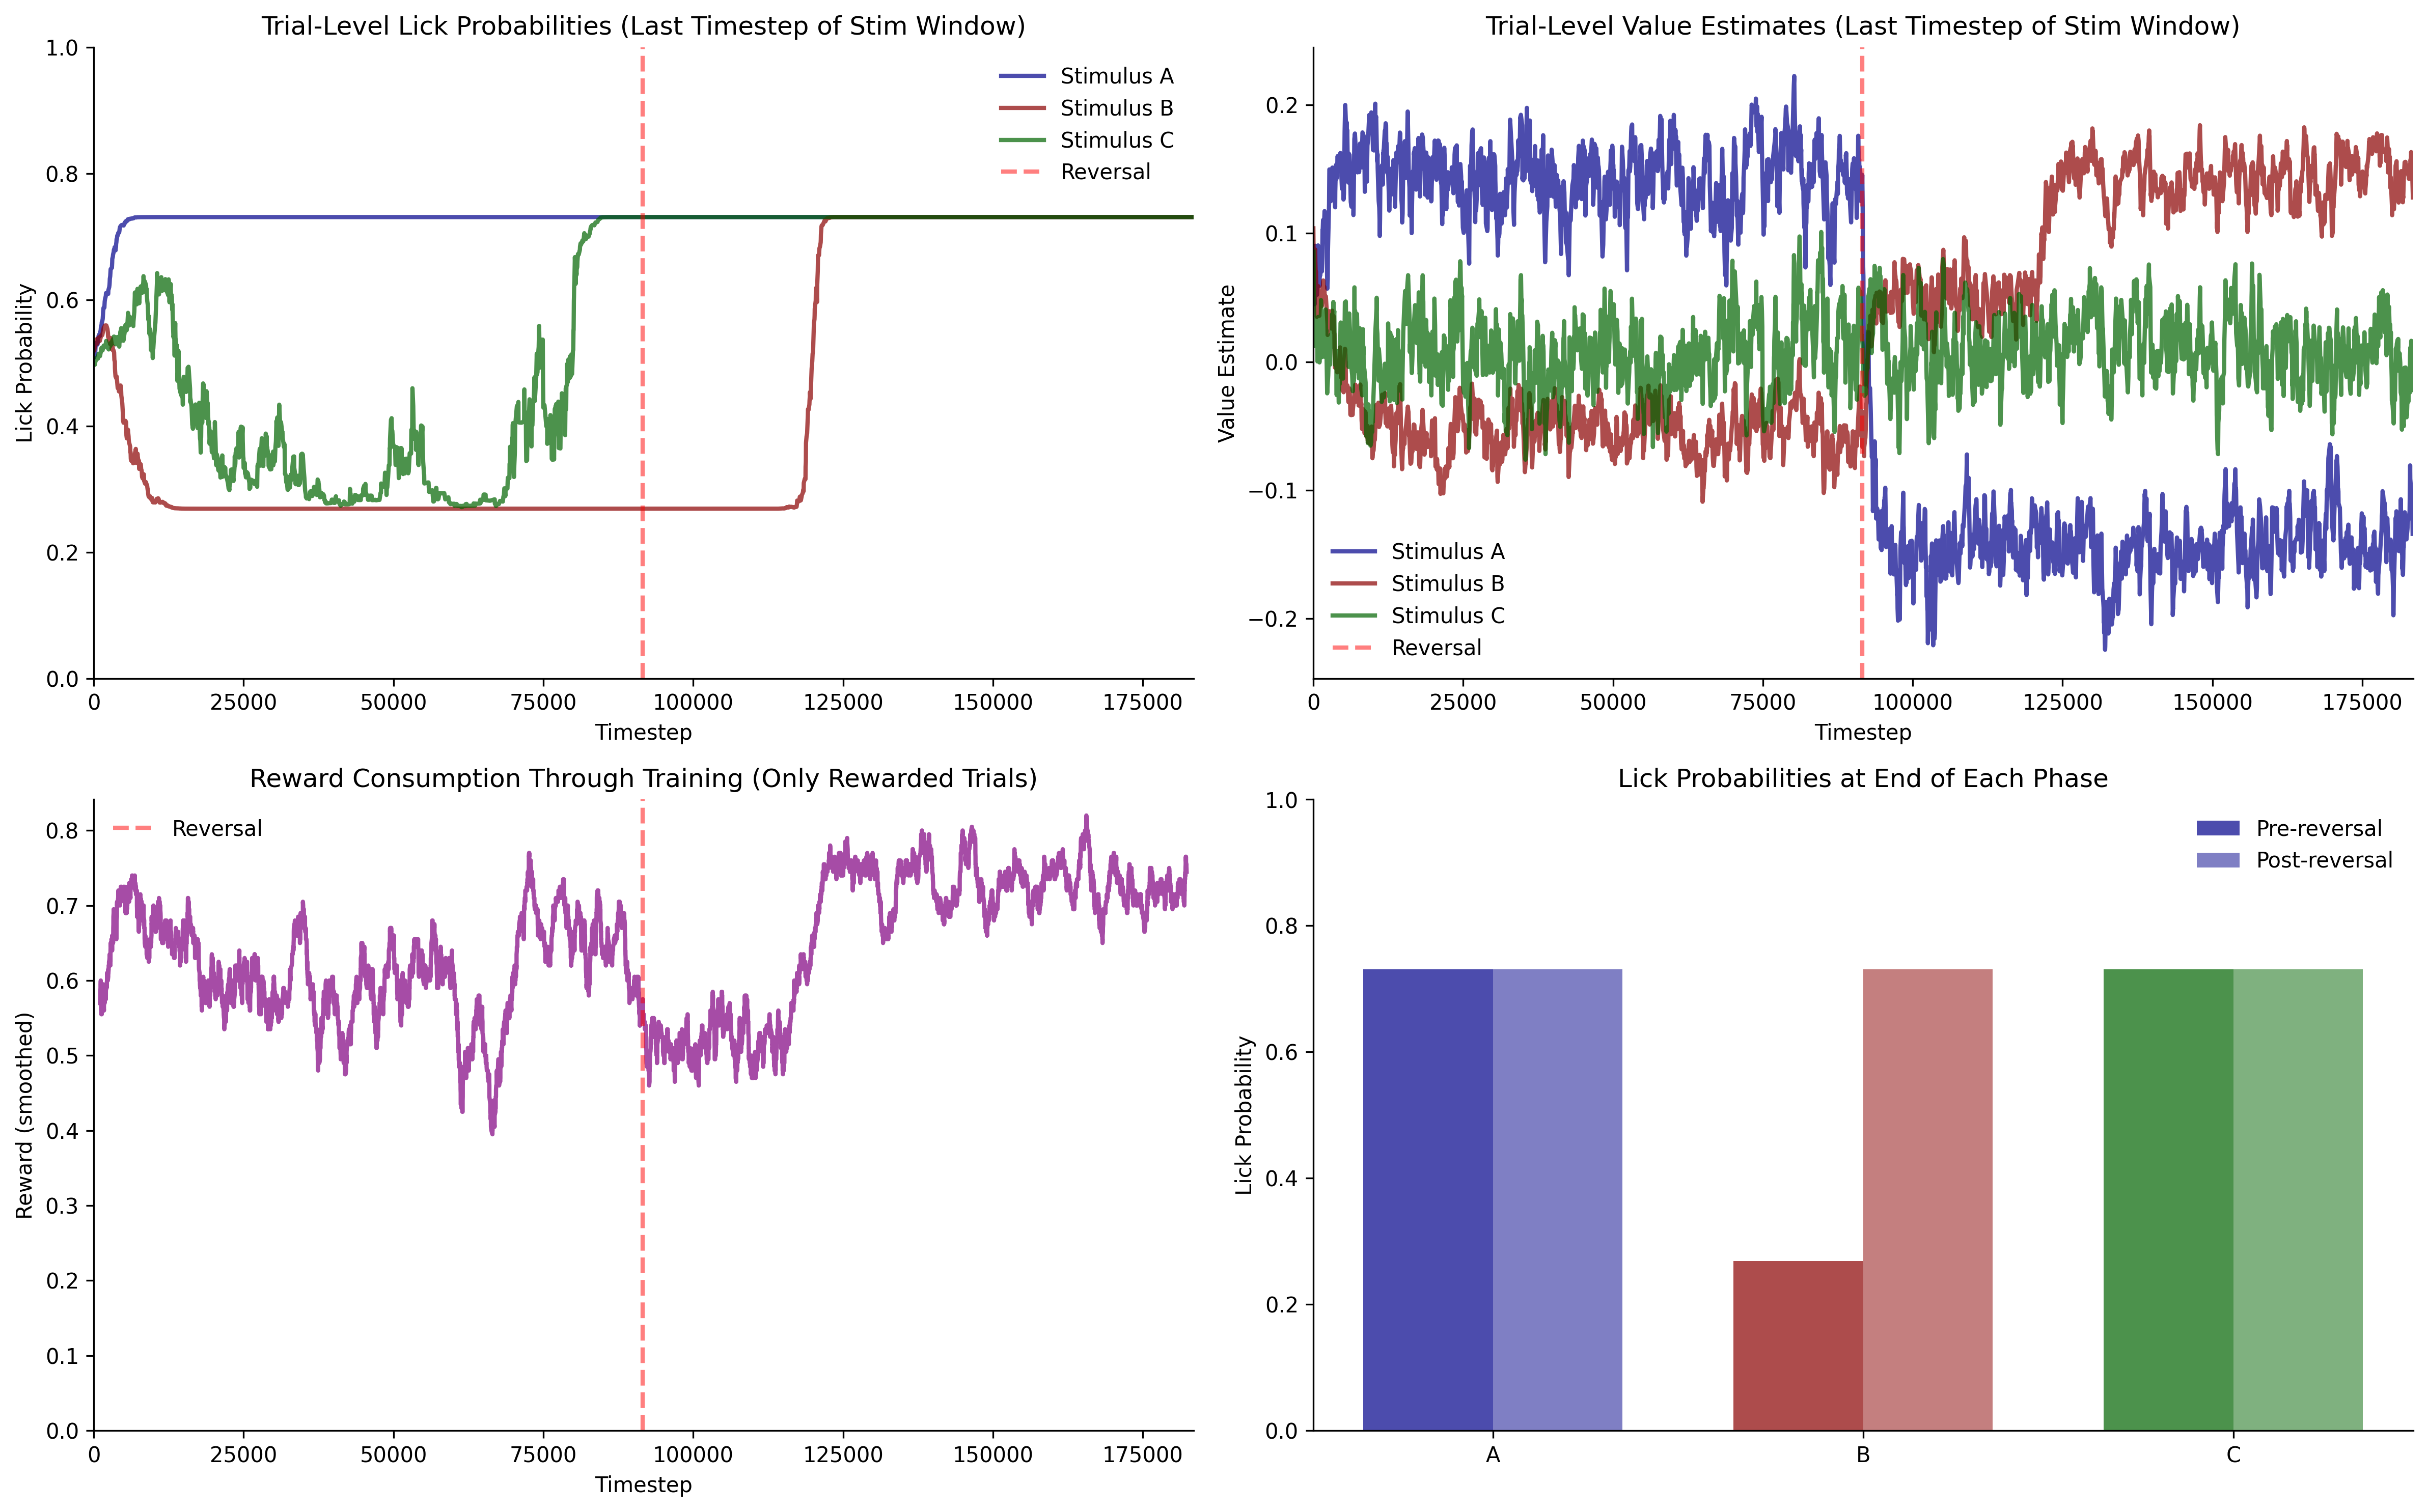

Visualisation complete!

Summary:
Mean reward: 0.6419
Final lick prob A: 0.731
Final lick prob B: 0.731
Final lick prob C: 0.731

Summary plot saved to /Users/pmccarthy/Documents/modelling_results/december_2025_a2c/reversal_abc_multitimestep/training_results.png


In [181]:
# Convert metrics to numpy arrays for plotting
# Use trial_lick_probs (last timestep of stim window per trial) instead of lick_probs (all stimulus presentations)
trial_lick_probs_A = metrics_numpy['trial_lick_probs']['A']
trial_lick_probs_B = metrics_numpy['trial_lick_probs']['B']
trial_lick_probs_C = metrics_numpy['trial_lick_probs']['C']
trial_values_A = metrics_numpy['trial_values']['A']
trial_values_B = metrics_numpy['trial_values']['B']
trial_values_C = metrics_numpy['trial_values']['C']
rewards = metrics_numpy['rewards']

# Get trial timesteps (filtered by stimulus)
all_trial_indices = metrics_numpy['trial_indices']
all_trial_timesteps = metrics_numpy['trial_timesteps']
all_trial_reversal_phases = metrics_numpy['trial_reversal_phases']

# Filter timesteps for each stimulus
trial_timesteps_A = all_trial_timesteps[np.array([trial_structure[idx]['stimulus'] == 0 for idx in all_trial_indices])]
trial_timesteps_B = all_trial_timesteps[np.array([trial_structure[idx]['stimulus'] == 1 for idx in all_trial_indices])]
trial_timesteps_C = all_trial_timesteps[np.array([trial_structure[idx]['stimulus'] == 2 for idx in all_trial_indices])]

# Create visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Trial-level lick probabilities over training (last timestep of stim window)
ax = axes[0, 0]
if len(trial_timesteps_A) == len(trial_lick_probs_A) and len(trial_timesteps_A) > 0:
    ax.plot(trial_timesteps_A, trial_lick_probs_A, label='Stimulus A', linewidth=2, color='darkblue', alpha=0.7)
if len(trial_timesteps_B) == len(trial_lick_probs_B) and len(trial_timesteps_B) > 0:
    ax.plot(trial_timesteps_B, trial_lick_probs_B, label='Stimulus B', linewidth=2, color='darkred', alpha=0.7)
if len(trial_timesteps_C) == len(trial_lick_probs_C) and len(trial_timesteps_C) > 0:
    ax.plot(trial_timesteps_C, trial_lick_probs_C, label='Stimulus C', linewidth=2, color='darkgreen', alpha=0.7)

# Mark reversal points
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, 
               label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Lick Probability')
ax.set_title('Trial-Level Lick Probabilities (Last Timestep of Stim Window)')
ax.legend()
ax.set_ylim([0, 1])
ax.set_xlim(0, len(state_sequence))

# Plot 2: Trial-level value estimates over training (last timestep of stim window)
ax = axes[0, 1]
if len(trial_timesteps_A) == len(trial_values_A) and len(trial_timesteps_A) > 0:
    ax.plot(trial_timesteps_A, trial_values_A, label='Stimulus A', linewidth=2, color='darkblue', alpha=0.7)
if len(trial_timesteps_B) == len(trial_values_B) and len(trial_timesteps_B) > 0:
    ax.plot(trial_timesteps_B, trial_values_B, label='Stimulus B', linewidth=2, color='darkred', alpha=0.7)
if len(trial_timesteps_C) == len(trial_values_C) and len(trial_timesteps_C) > 0:
    ax.plot(trial_timesteps_C, trial_values_C, label='Stimulus C', linewidth=2, color='darkgreen', alpha=0.7)

# Mark reversal points
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, 
               label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Value Estimate')
ax.set_title('Trial-Level Value Estimates (Last Timestep of Stim Window)')
ax.legend()
ax.set_xlim(0, len(state_sequence))

# Plot 3: Rewards over time (smoothed)
reward_timesteps = metrics_numpy['reward_timesteps']
ax = axes[1, 0]
# Smooth rewards with moving average
window_size = 200
if len(rewards) > window_size:
    smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    start_idx = window_size // 2
    smoothed_timesteps = reward_timesteps[start_idx:start_idx + len(smoothed_rewards)]
    ax.plot(smoothed_timesteps, smoothed_rewards, linewidth=2, color='purple', alpha=0.7)
else:
    ax.plot(reward_timesteps, rewards, linewidth=1, color='purple', alpha=0.5)

# Mark reversal points
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, 
               label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Reward (smoothed)')
ax.set_title('Reward Consumption Through Training (Only Rewarded Trials)')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(0, len(state_sequence))


# Get values at end of pre-reversal and post-reversal
# Use timesteps and lick_probs from metrics_numpy (all stimulus presentations, not just trial-level)
timesteps_A = metrics_numpy['timesteps_A']
timesteps_B = metrics_numpy['timesteps_B']
timesteps_C = metrics_numpy['timesteps_C']
lick_probs_A = metrics_numpy['lick_probs']['A']
lick_probs_B = metrics_numpy['lick_probs']['B']
lick_probs_C = metrics_numpy['lick_probs']['C']

# Plot 4: Final performance comparison (end of each phase)
ax = axes[1, 1]

def get_value_at_timestep(timesteps, values, target_timestep):
    """Get the last value before or at target_timestep."""
    mask = timesteps <= target_timestep
    if np.any(mask):
        idx = np.where(mask)[0][-1]
        return values[idx]
    return None

# Get values at end of pre-reversal and post-reversal
pre_end_vals = {'A': [], 'B': [], 'C': []}
post_end_vals = {'A': [], 'B': [], 'C': []}

if len(timesteps_A) > 0 and len(lick_probs_A) > 0:
    val = get_value_at_timestep(timesteps_A, lick_probs_A, pre_end)
    if val is not None:
        pre_end_vals['A'].append(val)
    val = get_value_at_timestep(timesteps_A, lick_probs_A, post_end)
    if val is not None:
        post_end_vals['A'].append(val)

if len(timesteps_B) > 0 and len(lick_probs_B) > 0:
    val = get_value_at_timestep(timesteps_B, lick_probs_B, pre_end)
    if val is not None:
        pre_end_vals['B'].append(val)
    val = get_value_at_timestep(timesteps_B, lick_probs_B, post_end)
    if val is not None:
        post_end_vals['B'].append(val)

if len(timesteps_C) > 0 and len(lick_probs_C) > 0:
    val = get_value_at_timestep(timesteps_C, lick_probs_C, pre_end)
    if val is not None:
        pre_end_vals['C'].append(val)
    val = get_value_at_timestep(timesteps_C, lick_probs_C, post_end)
    if val is not None:
        post_end_vals['C'].append(val)

# Prepare data for grouped bar chart
stimuli = []
pre_means = []
post_means = []
colors_map = {'A': 'darkblue', 'B': 'darkred', 'C': 'darkgreen'}
colors = []

for stim in ['A', 'B', 'C']:
    if len(pre_end_vals[stim]) > 0 or len(post_end_vals[stim]) > 0:
        stimuli.append(stim)
        pre_means.append(np.mean(pre_end_vals[stim]) if len(pre_end_vals[stim]) > 0 else 0)
        post_means.append(np.mean(post_end_vals[stim]) if len(post_end_vals[stim]) > 0 else 0)
        colors.append(colors_map[stim])

if len(stimuli) > 0:
    x = np.arange(len(stimuli))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, pre_means, width, label='Pre-reversal', color=colors, alpha=0.7)
    bars2 = ax.bar(x + width/2, post_means, width, label='Post-reversal', color=colors, alpha=0.5)
    
    ax.set_ylabel('Lick Probability')
    ax.set_title('Lick Probabilities at End of Each Phase')
    ax.set_xticks(x)
    ax.set_xticklabels(stimuli)
    ax.legend()
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Save summary plot
fig.savefig(save_path / "training_results.png", dpi=300, bbox_inches='tight')

print("Visualisation complete!")
print(f"\nSummary:")
print(f"Mean reward: {np.mean(rewards):.4f}")
if len(lick_probs_A) > 0:
    print(f"Final lick prob A: {lick_probs_A[-1]:.3f}")
if len(lick_probs_B) > 0:
    print(f"Final lick prob B: {lick_probs_B[-1]:.3f}")
if len(lick_probs_C) > 0:
    print(f"Final lick prob C: {lick_probs_C[-1]:.3f}")
print(f"\nSummary plot saved to {save_path / 'training_results.png'}")


---
Trial-level model behaviour

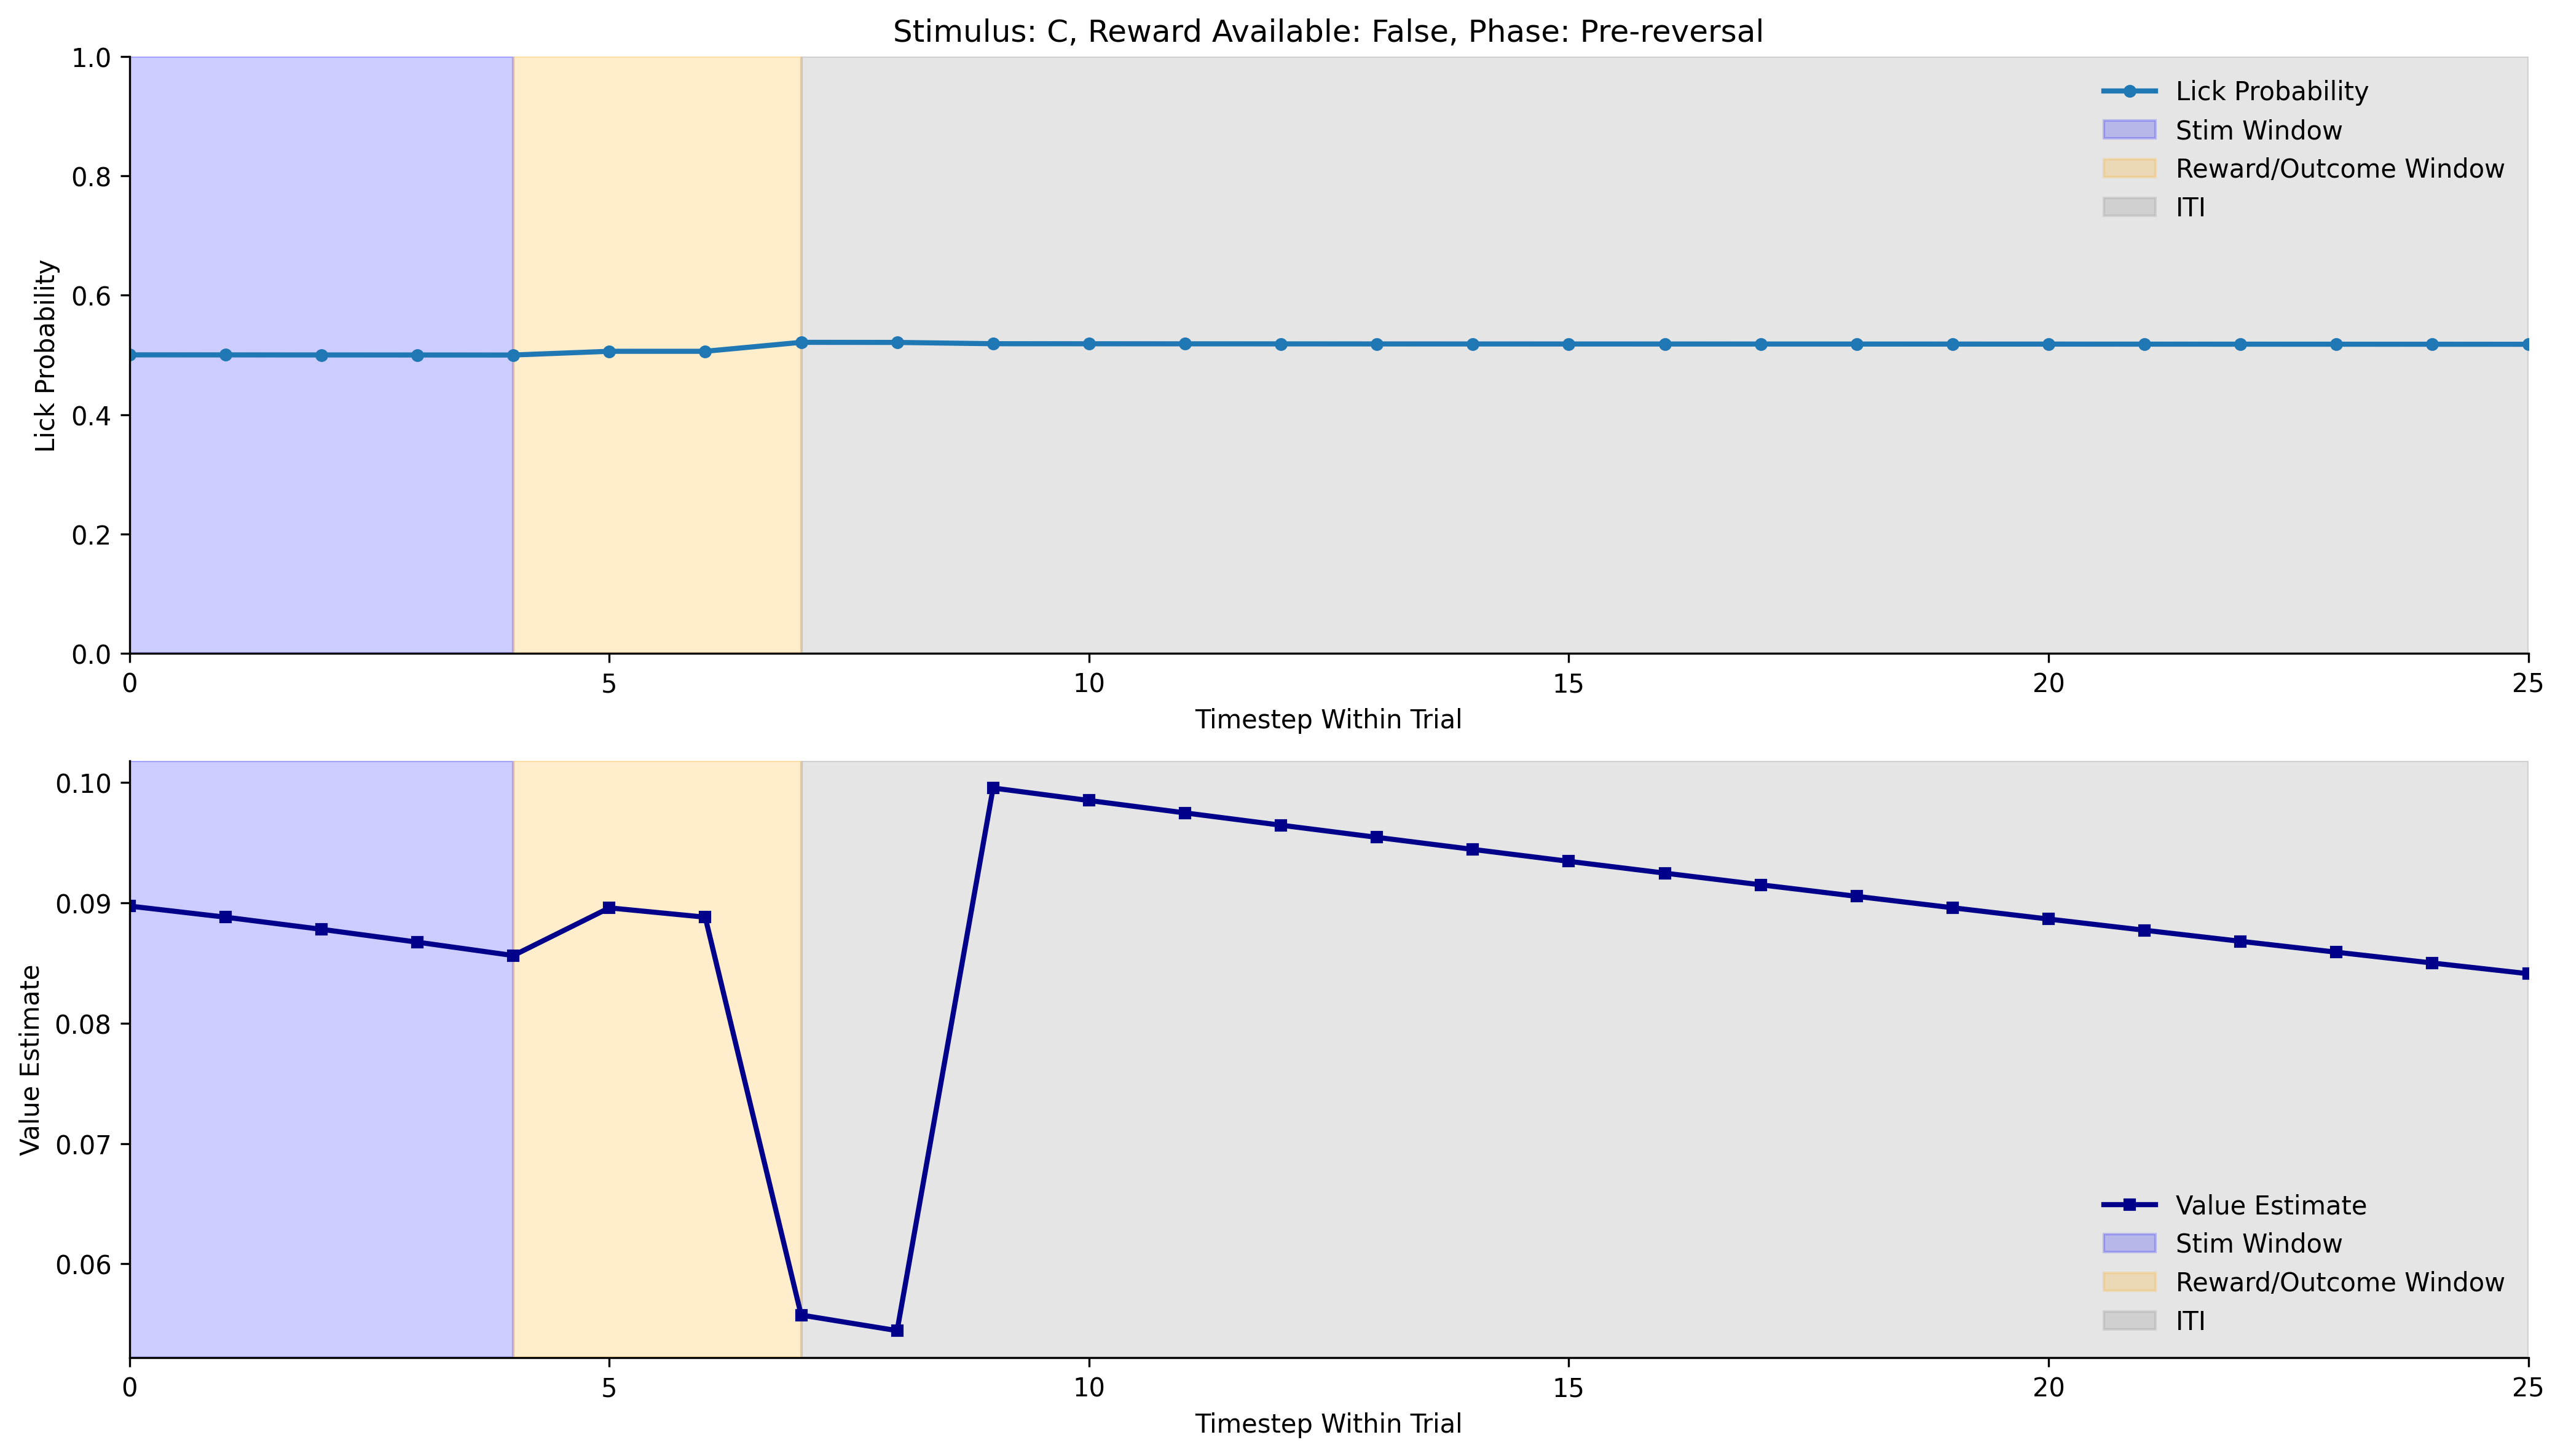

Trial 1 info:
  Stimulus: 2
  Reward Available: False
  Phase: Pre-reversal
  Timesteps: 26 to 51
  States encountered: {'reward_unknown', 'B', 'unrewarded', 'ITI', 'C'}


In [187]:
# Select a trial by index to plot
trial_idx_to_plot = 1  # Change this to select different trials

if trial_idx_to_plot in metrics_numpy['within_trial_lick_probs']:
    trial_lick_probs = metrics_numpy['within_trial_lick_probs'][trial_idx_to_plot]
    trial_values = metrics_numpy['within_trial_values'][trial_idx_to_plot]
    trial_timesteps = metrics_numpy['within_trial_timesteps'][trial_idx_to_plot]
    trial_states = metrics_numpy['within_trial_states'][trial_idx_to_plot]
    
    # Get trial info
    trial_info = trial_structure[trial_idx_to_plot]
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Convert absolute timesteps to relative (starting from 0)
    trial_start = trial_info['trial_start']
    trial_timesteps_rel = np.array(trial_timesteps) - trial_start
    
    stim_name = get_dict_key(state_map, trial_info["stimulus"])  # Example usage

    # Plot lick probabilities
    ax = axes[0]
    ax.plot(trial_timesteps_rel, trial_lick_probs, 'o-', label='Lick Probability', linewidth=2, markersize=4)
    ax.set_xlabel('Timestep Within Trial')
    ax.set_ylabel('Lick Probability')
    ax.set_title(f'Stimulus: {stim_name}, '
                 f'Reward Available: {trial_info["reward_available"]}, '
                 f'Phase: {"Pre-reversal" if trial_info["reversal_phase"] == 0 else "Post-reversal"}')
    ax.set_ylim([0, 1])
    ax.set_xlim([trial_timesteps_rel[0], trial_timesteps_rel[-1]])
    
    # Add vertical lines and shaded regions for phase boundaries
    stim_start_rel = trial_info['stim_window'][0] - trial_start
    stim_end_rel = trial_info['stim_window'][-1] - trial_start
    reward_start_rel = trial_info['reward_window'][0] - trial_start
    reward_end_rel = trial_info['reward_window'][-1] - trial_start
    iti_start_rel = trial_info['iti_window'][0] - trial_start if trial_info.get('iti_window') else None
    iti_end_rel = trial_info['iti_window'][-1] - trial_start if trial_info.get('iti_window') else None
    
    # Shade regions
    ax.axvspan(stim_start_rel, stim_end_rel, alpha=0.2, color='blue', label='Stim Window')
    ax.axvspan(reward_start_rel-1, reward_end_rel, alpha=0.2, color='orange', label='Reward/Outcome Window')
    if iti_start_rel is not None:
        ax.axvspan(iti_start_rel-1, iti_end_rel, alpha=0.2, color='gray', label='ITI')
    
    ax.legend()


    # Plot value estimates
    ax = axes[1]
    ax.plot(trial_timesteps_rel, trial_values, 's-', label='Value Estimate', linewidth=2, markersize=4, color='darkblue')
    ax.set_xlabel('Timestep Within Trial')
    ax.set_ylabel('Value Estimate')
    ax.set_xlim([trial_timesteps_rel[0], trial_timesteps_rel[-1]])

    
    # Add same phase boundaries
    ax.axvspan(stim_start_rel, stim_end_rel, alpha=0.2, color='blue', label='Stim Window')
    ax.axvspan(reward_start_rel-1, reward_end_rel, alpha=0.2, color='orange', label='Reward/Outcome Window')
    if iti_start_rel is not None:
        ax.axvspan(iti_start_rel-1, iti_end_rel, alpha=0.2, color='gray', label='ITI')

    ax.legend()

    plt.tight_layout()
    plt.show()
    
    print(f"Trial {trial_idx_to_plot} info:")
    print(f"  Stimulus: {trial_info['stimulus']}")
    print(f"  Reward Available: {trial_info['reward_available']}")
    print(f"  Phase: {'Pre-reversal' if trial_info['reversal_phase'] == 0 else 'Post-reversal'}")
    print(f"  Timesteps: {trial_info['trial_start']} to {trial_info['trial_end']}")
    print(f"  States encountered: {set(trial_states)}")
else:
    print(f"Trial {trial_idx_to_plot} not found in metrics")


---
Within-Trial Dynamics Across Training Stages


Max ITI end: 0


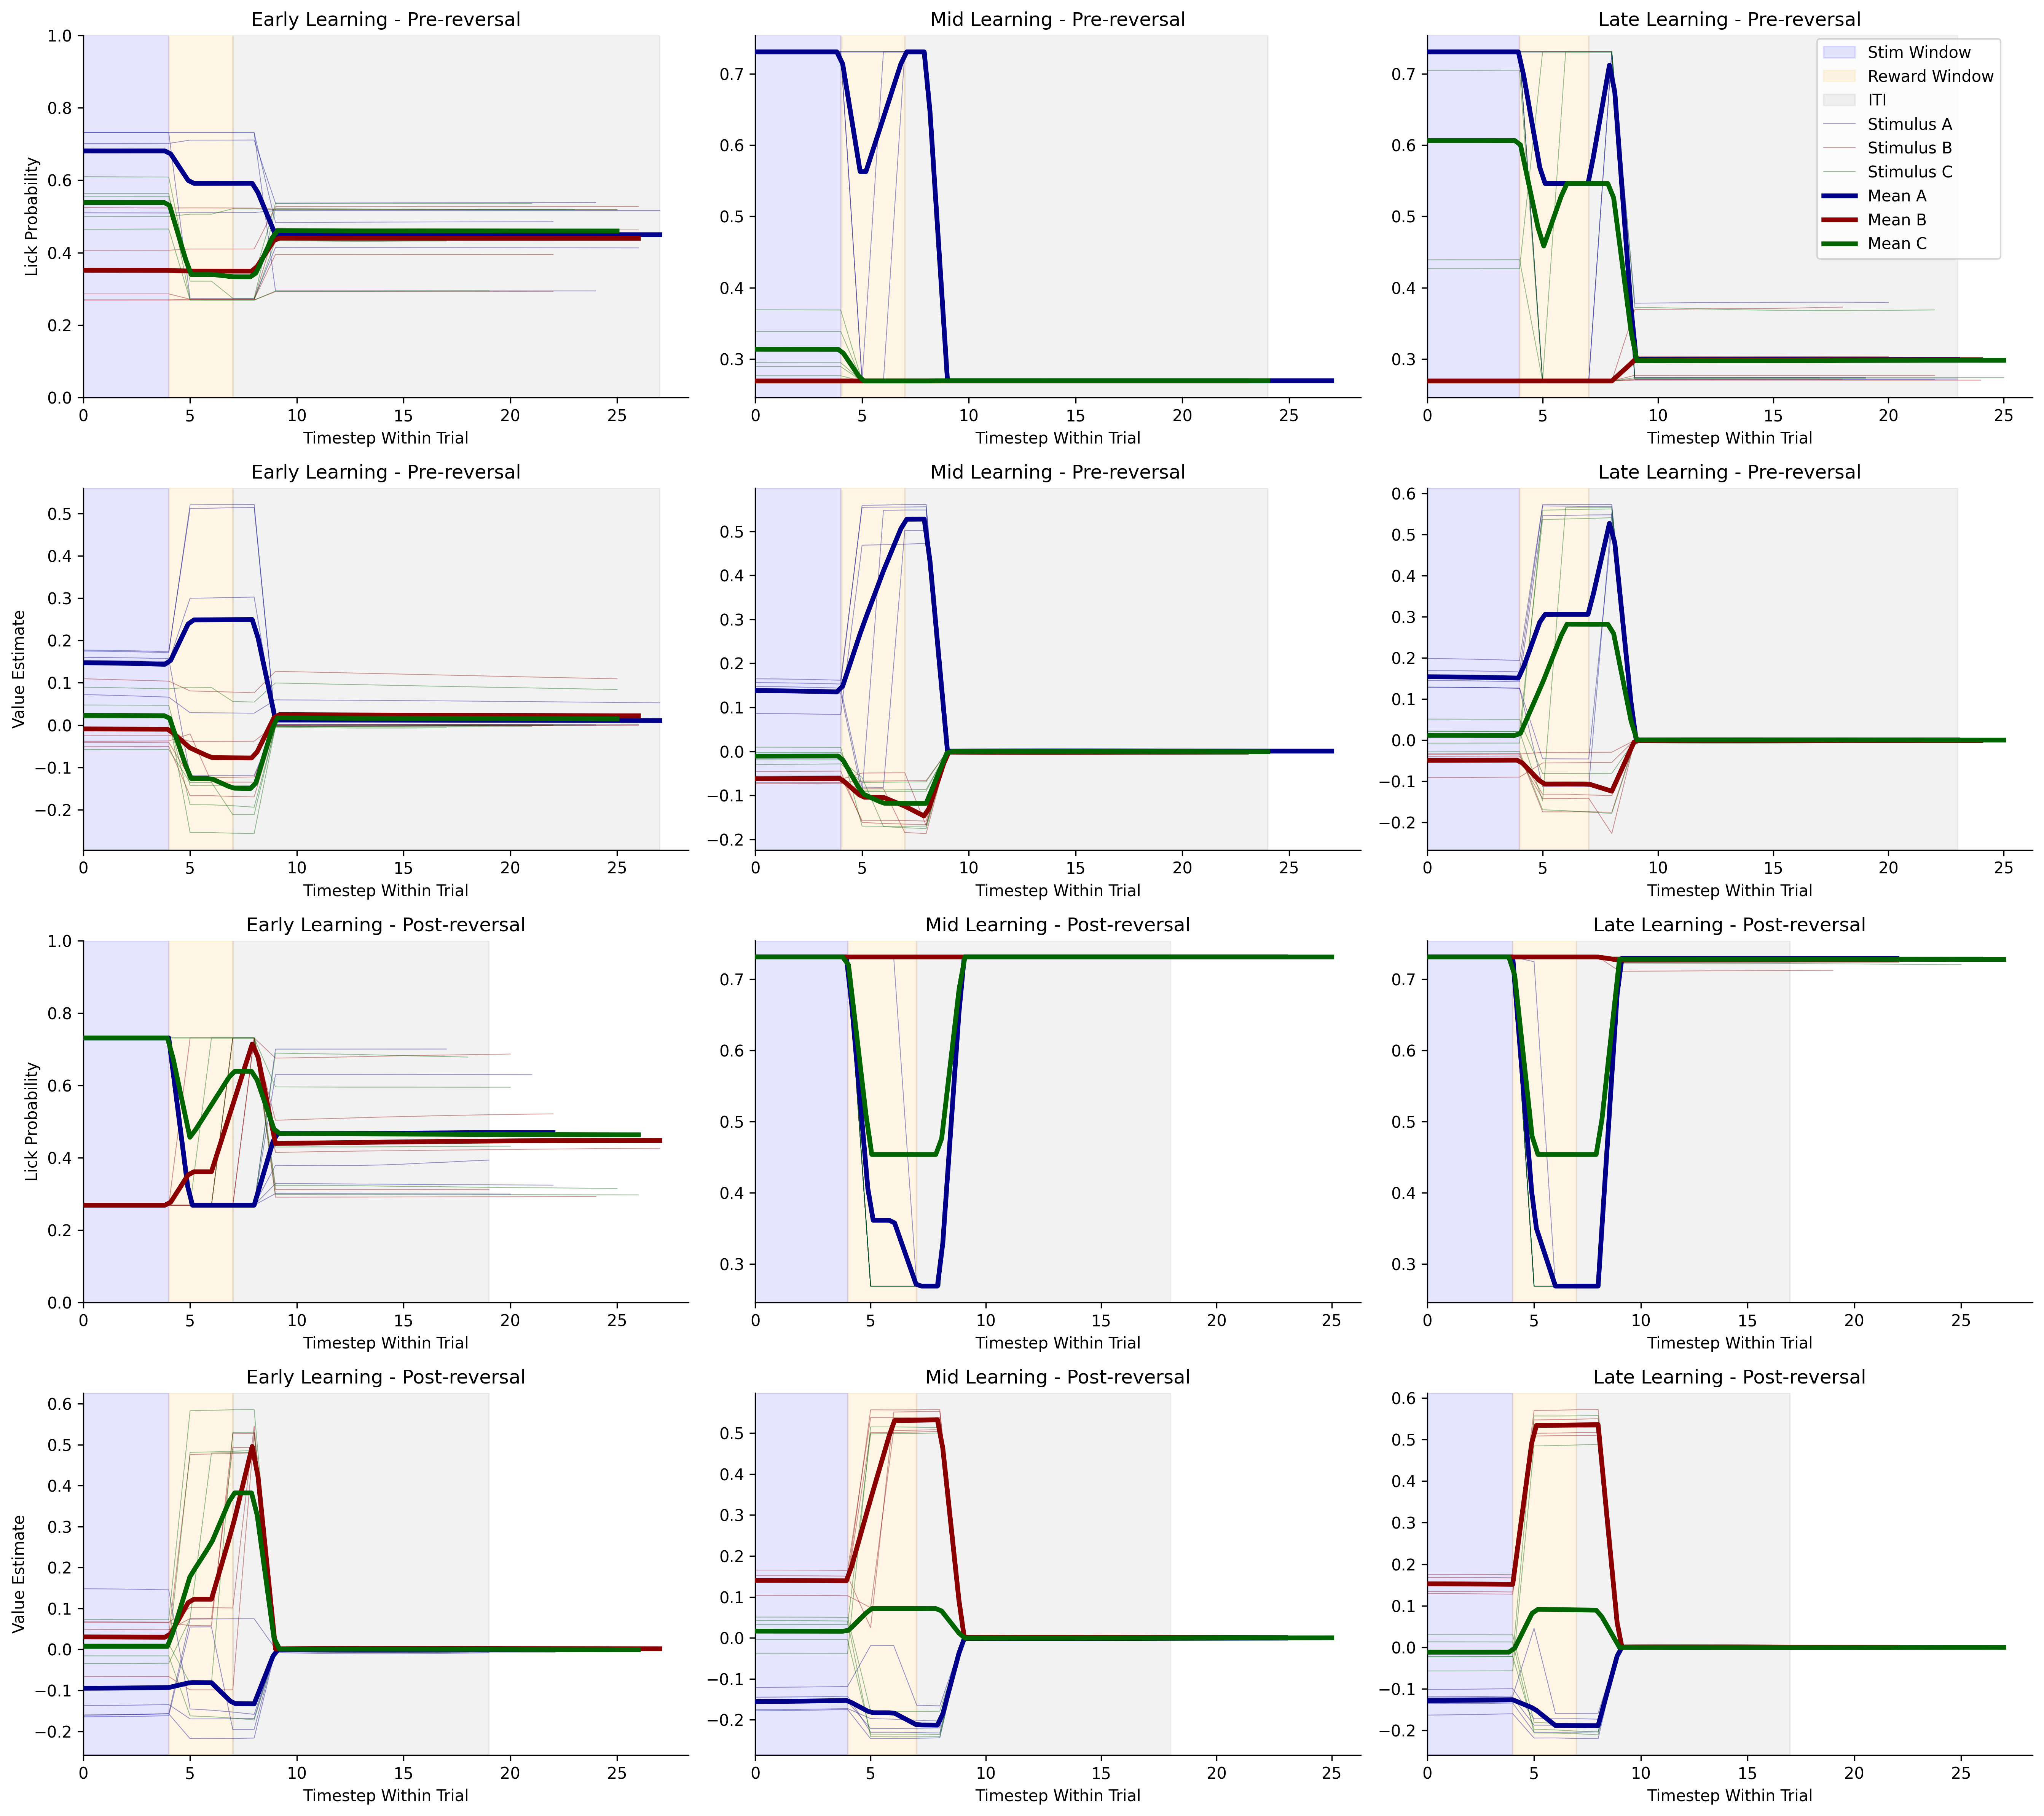


Grid plot saved to /Users/pmccarthy/Documents/modelling_results/december_2025_a2c/reversal_abc_multitimestep/within_trial_dynamics_grid.png

Summary of extracted trials:
  Early Pre: 15 trials total
  Early Post: 15 trials total
  Mid Pre: 15 trials total
  Mid Post: 15 trials total
  Late Pre: 15 trials total
  Late Post: 15 trials total


In [192]:
# Configuration for trial extraction
num_trials_per_stage = 5  # Number of trials to extract from each stage
early_window = (0.0, 0.2)  # First 20% of phase
mid_window = (0.4, 0.6)   # Middle 40-60% of phase
late_window = (0.8, 1.0)  # Last 20% of phase

# Get trial boundaries separated by phase
pre_trials = [tb for tb in metrics_numpy['trial_boundaries'] if tb['reversal_phase'] == 0]
post_trials = [tb for tb in metrics_numpy['trial_boundaries'] if tb['reversal_phase'] == 1]

def select_trials_by_position(trial_list, position_range, stimulus, num_trials):
    """Select trials from a specific position range and stimulus."""
    start_idx = int(len(trial_list) * position_range[0])
    end_idx = int(len(trial_list) * position_range[1])
    candidate_trials = trial_list[start_idx:end_idx]
    
    # Filter by stimulus (stimulus is stored as integer: 0=A, 1=B, 2=C)
    stimulus_trials = [t for t in candidate_trials if t['stimulus'] == stimulus]
    
    # Select evenly spaced trials
    if len(stimulus_trials) == 0:
        return []
    if len(stimulus_trials) <= num_trials:
        return [t['trial_idx'] for t in stimulus_trials]
    
    indices = np.linspace(0, len(stimulus_trials) - 1, num_trials, dtype=int)
    return [stimulus_trials[i]['trial_idx'] for i in indices]

# Select trials for each stage and stimulus
selected_trials = {}
for phase_name, position_range in [('early', early_window), ('mid', mid_window), ('late', late_window)]:
    selected_trials[phase_name] = {}
    for phase_type in ['pre', 'post']:
        selected_trials[phase_name][phase_type] = {}
        trial_list = pre_trials if phase_type == 'pre' else post_trials
        
        for stim_int, stim_name in [(0, 'A'), (1, 'B'), (2, 'C')]:
            trial_indices = select_trials_by_position(trial_list, position_range, stim_int, num_trials_per_stage)
            selected_trials[phase_name][phase_type][stim_name] = trial_indices


# Create grid plot: 4 rows (policy pre, value pre, policy post, value post) × 3 columns (early, mid, late)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))

# Color map for stimuli (matching the "Visualise Results" cell)
stim_colors = {'A': 'darkblue', 'B': 'darkred', 'C': 'darkgreen'}

# Row labels
stage_labels = ['Early', 'Mid', 'Late']

# Plot each combination
for row_idx, (row_label, phase_type, metric_type) in enumerate([
    ('Policy Pre-reversal', 'pre', 'lick_probs'),
    ('Value Pre-reversal', 'pre', 'values'),
    ('Policy Post-reversal', 'post', 'lick_probs'),
    ('Value Post-reversal', 'post', 'values')
]):
    for col_idx, (stage_name, stage_range) in enumerate([
        ('early', early_window),
        ('mid', mid_window),
        ('late', late_window)
    ]):
        ax = axes[row_idx, col_idx]
        
        # Get phase boundaries from first trial (they should be similar across trials)
        first_trial_idx = None
        for stim_name in ['A', 'B', 'C']:
            if selected_trials[stage_name][phase_type][stim_name]:
                first_trial_idx = selected_trials[stage_name][phase_type][stim_name][0]
        
        # Calculate max ITI end for this subplot (across all 15 trials)
        subplot_max_iti_end = 0
        for stim_name in ['A', 'B', 'C']:
            for trial_idx in selected_trials[stage_name][phase_type][stim_name]:
                if trial_idx in trial_structure:
                    trial_info = trial_structure[trial_idx]
                    if 'iti_window' in trial_info and trial_info['iti_window'] and len(trial_info['iti_window']) > 0:
                        trial_start = trial_info['trial_start']
                        iti_end_rel = trial_info['iti_window'][-1] - trial_start
                        subplot_max_iti_end = max(subplot_max_iti_end, iti_end_rel)
                break
        
        # Initialize variables for phase boundaries
        stim_start_rel = 0
        stim_end_rel = 0
        reward_start_rel = 0
        reward_end_rel = 0
        iti_start_rel = None
        iti_end_rel = None
        
        if first_trial_idx is not None and first_trial_idx in metrics_numpy['within_trial_lick_probs']:
            first_trial_info = trial_structure[first_trial_idx]
            trial_start = first_trial_info['trial_start']
            stim_start_rel = first_trial_info['stim_window'][0] - trial_start
            stim_end_rel = first_trial_info['stim_window'][-1] - trial_start
            reward_start_rel = first_trial_info['reward_window'][0] - trial_start
            reward_end_rel = first_trial_info['reward_window'][-1] - trial_start
            
            # Shade phase regions (only add labels on first subplot to avoid duplicates)
            # Get phase boundaries from first trial if available
            if first_trial_idx is not None and first_trial_idx in metrics_numpy['within_trial_lick_probs']:
                # Shade stim and reward windows
                if row_idx == 0 and col_idx == 0:
                    ax.axvspan(stim_start_rel, stim_end_rel, alpha=0.1, color='blue', label='Stim Window')
                    ax.axvspan(reward_start_rel-1, reward_end_rel, alpha=0.1, color='orange', label='Reward Window')
                else:
                    ax.axvspan(stim_start_rel, stim_end_rel, alpha=0.1, color='blue')
                    ax.axvspan(reward_start_rel-1, reward_end_rel, alpha=0.1, color='orange')
            
            # Always apply ITI shading using subplot_max_iti_end
            # Calculate reward_end_rel if not already set
            if reward_end_rel == 0:
                # Try to get from any selected trial
                any_trial_idx = None
                for stim_name in ['A', 'B', 'C']:
                    if selected_trials[stage_name][phase_type][stim_name]:
                        any_trial_idx = selected_trials[stage_name][phase_type][stim_name][0]
                        break
                if any_trial_idx is not None and any_trial_idx in trial_structure:
                    any_trial_info = trial_structure[any_trial_idx]
                    any_trial_start = any_trial_info['trial_start']
                    reward_end_rel = any_trial_info['reward_window'][-1] - any_trial_start
                else:
                    # Fallback: use standard structure (stim_window=5, reward_window=3)
                    reward_end_rel = 5 + 3  # stim_window + reward_window
            
            # Apply ITI shading with subplot_max_iti_end
            if subplot_max_iti_end > 0:
                iti_start = reward_end_rel + 1
                if row_idx == 0 and col_idx == 0:
                    ax.axvspan(iti_start, subplot_max_iti_end, alpha=0.1, color='gray', label='ITI')
                else:
                    ax.axvspan(iti_start, subplot_max_iti_end, alpha=0.1, color='gray')
        # Collect data for mean calculation
        stim_data_for_mean = {'A': [], 'B': [], 'C': []}
        stim_timesteps_for_mean = {'A': [], 'B': [], 'C': []}
        
        # Track which stimuli are plotted for legend
        plotted_stimuli = set()
        
        # Plot trials for each stimulus
        for stim_name in ['A', 'B', 'C']:
            trial_indices = selected_trials[stage_name][phase_type][stim_name]
            color = stim_colors[stim_name]
            
            for trial_idx in trial_indices:
                if trial_idx in metrics_numpy[f'within_trial_{metric_type}']:
                    trial_data = metrics_numpy[f'within_trial_{metric_type}'][trial_idx]
                    trial_timesteps = metrics_numpy['within_trial_timesteps'][trial_idx]
                    trial_info = trial_structure[trial_idx]
                    
                    # Normalize timesteps to start at 0 (relative to trial start)
                    trial_start = trial_info['trial_start']
                    trial_timesteps_norm = np.array(trial_timesteps) - trial_start
                    
                    # Plot with label only for first trial of each stimulus type (on first subplot)
                    if row_idx == 0 and col_idx == 0 and stim_name not in plotted_stimuli:
                        label = f'Stimulus {stim_name}'
                        plotted_stimuli.add(stim_name)
                    else:
                        label = None
                    
                    ax.plot(trial_timesteps_norm, trial_data, '-', 
                           color=color, alpha=0.4, linewidth=0.5, label=label)
                    
                    # Collect data for mean calculation
                    stim_data_for_mean[stim_name].append((trial_timesteps_norm, trial_data))
        
        # Plot mean traces for each stimulus
        for stim_name in ['A', 'B', 'C']:
            if len(stim_data_for_mean[stim_name]) > 0:
                # Find common timestep range
                all_timesteps = []
                for timesteps, _ in stim_data_for_mean[stim_name]:
                    all_timesteps.extend(timesteps.tolist())
                
                if len(all_timesteps) > 0:
                    # Create common timestep grid
                    common_timesteps = np.linspace(0, max(all_timesteps), 100)
                    interpolated_data = []
                    
                    for timesteps, data in stim_data_for_mean[stim_name]:
                        if len(timesteps) > 1 and len(data) == len(timesteps):
                            try:
                                # Interpolate to common timesteps using numpy
                                interp_data = np.interp(common_timesteps, timesteps, data)
                                interpolated_data.append(interp_data)
                            except:
                                pass
                    
                    if len(interpolated_data) > 0:
                        # Calculate mean across interpolated traces
                        interpolated_array = np.array(interpolated_data)
                        mean_data = np.nanmean(interpolated_array, axis=0)
                        
                        # Plot mean trace
                        color = stim_colors[stim_name]
                        label = f'Mean {stim_name}' if row_idx == 0 and col_idx == 0 else None
                        ax.plot(common_timesteps, mean_data, '-', color=color, alpha=1.0, linewidth=3, 
                               label=label, zorder=10)
        
        # Set labels and limits
        ax.set_xlabel('Timestep Within Trial')
        ax.set_xlim(left=0)  # Ensure x-axis starts from 0
        
        # Set title with phase label
        if row_idx == 0:
            ax.set_title(f'{stage_labels[col_idx]} Learning - Pre-reversal')
        elif row_idx == 1:
            ax.set_title(f'{stage_labels[col_idx]} Learning - Pre-reversal')
        elif row_idx == 2:
            ax.set_title(f'{stage_labels[col_idx]} Learning - Post-reversal')
        else:  # row_idx == 3
            ax.set_title(f'{stage_labels[col_idx]} Learning - Post-reversal')
        
        if col_idx == 0:
            if metric_type == 'lick_probs':
                ax.set_ylabel('Lick Probability')
                ax.set_ylim([0, 1])
            else:
                ax.set_ylabel('Value Estimate')

# Add overall title
# fig.suptitle('Within-Trial Dynamics Across Training Stages', fontsize=16, y=0.995)

# Collect legend handles and labels from first subplot (which has all the labels)
handles, labels = axes[0, 0].get_legend_handles_labels()

# Add global legend in top right
if handles:
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
               frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

# Save plot
fig.savefig(save_path / "within_trial_dynamics_grid.png", dpi=300, bbox_inches='tight')
print(f"\nGrid plot saved to {save_path / 'within_trial_dynamics_grid.png'}")

# Print summary
print(f"\nSummary of extracted trials:")
for stage_name in ['early', 'mid', 'late']:
    for phase_type in ['pre', 'post']:
        total = sum(len(selected_trials[stage_name][phase_type][s]) for s in ['A', 'B', 'C'])
        print(f"  {stage_name.capitalize()} {phase_type.capitalize()}: {total} trials total")

